# **STUDENT AI** - MATH MODEL CREATION (CLASSIFICATION)

## Objectives

Create a classification model to predict Math score based on Key dataset features. Numerical variables will be grouped into bins. <br> 
Since the 5 bin classification did not yield promising results, the same steps will be repeated using the 3 bin classification.

## Inputs

Continues to assess dataset loaded in previous notebook.

## Outputs

None. Assesses whether the 3 bin approaach is viable.


---

# Import required libraries

In [2]:
import os
import io
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Pipeline
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### libraries for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Feature Balancing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score
from IPython.display import display, HTML

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

### GridSearchCV
from sklearn.model_selection import GridSearchCV

### Load Custom Functions
import io
import sys
sys.path.append('/workspace/student-AI/src')
from data_management import save_analysis
from data_management import confusion_matrix_and_report, clf_performance

print('All Libraries Loaded')

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


All Libraries Loaded


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from best to bottom.

In [3]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


# Define Features and Settings to include in Model analysis

### Load full dataset and to help choose which features and target to select

In [4]:
# Path to csv dataset
source = 'outputs/dataset/Expanded_data_with_more_features_clean.csv'

In [5]:
df = pd.read_csv(source)

# Capture df.info()
buffer = io.StringIO()
df.info(buf=buffer)
info_str = buffer.getvalue()

# Convert df.describe() to HTML
describe_str = df.describe().to_html()

# Display df.info() and df.describe() side by side with titles
display(HTML(f"""
    <table>
        <tr>
            <th style="text-align:center">DataSet Summary</th>
            <th style="text-align:center">DataSet Statistics (for Numerical Variables)</th>
        </tr>
        <tr>
            <td><pre>{info_str}</pre></td>
            <td>{describe_str}</td>
        </tr>
    </table>
"""))

### Choosing Feature Variables

nrSiblings is treated as a numerical variable (int64). 

As I determined previously it has no bearing on the target variables, so I will drop it rather than convert to categorical. 

The other variables previously identified in the EDA as having not much impact, I will keep in, as the Feature Selection step did not suggest to eliminate any. I will also drop the features that the EDA determined has no bearing on the target variables.

### Use summary above to setup which type of model to test / create
once the test / performance is satifactory, set **save_model** to **True** to output the model to disk.

In [15]:
# setup features and target variable from dataset to use for model training
feature_list = ['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep']
target_variable = 'MathScore'
filters = feature_list + [target_variable]

# set random state number (for reproducable results)
rs = 42

# set number of desired classes for discretizer
classes = 3

if classes == 2:
    class_labels = ['Might need assistance', 'No assistance needed']
elif classes == 3:
    class_labels = ['Might need assistance', 'Average', 'Above Avg']
elif classes == 5:
    class_labels = ['Will need assistance', 'Might need assistance', 'Avg', 'Above Avg', 'Excellent']
else:
    class_labels = [f'Class {i+1}' for i in range(classes)]
    
# Enable Traninig Set Balancing for Model
balance = True   

# Set the top n models to test from calculated best model list
n = 2

# Save model to disk?
save_model = False

# Set Model Version
version = "v2"

---

### Filter dataset
filters the data set to only include the features selected above.

In [7]:
df = df.filter(filters)
df

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,C,bachelor,standard,not completed,71
1,female,C,college,standard,not completed,69
2,female,B,masters,standard,not completed,87
3,male,A,associates,free,not completed,45
4,male,C,college,standard,not completed,76
...,...,...,...,...,...,...
30636,female,D,highschool,standard,not completed,59
30637,male,E,highschool,standard,not completed,58
30638,female,C,highschool,free,completed,61
30639,female,D,associates,standard,completed,82


### Setup test pipeline for evaluation

The steps for a classification model are a little more involved when using a dataset with a numerical target variable

| Step |  Purpose | 
|---|---|
|Data Cleaning|Deal with missing data or wrong data - step already completed in the saved dataset|
|Discretize Numerical Target|group target variable into bins for categorization|
|Encode Categorical Features|Model algorithms can only handle numerical data. Needs to be converted first|
|Data Balancing|Classification models are affected negatively by imbalanced data. SMOTE or Undersampling needs to be performed to balance the dataset|
|Feature Smart Correlation|Determine which features are most significant and eliminate uneccessary ones - helps prevent overfitting - **not neccesary**|
|Feature Selection|Select which features will be used |
|Algorithm Selection|Assess best algorithm for the data set as well as the best associated Parameters and Hyperparameters|
|Model Training|Train the model on the train data and evaluate with the test set|

In [8]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary', 
            variables=feature_list
                )
                ),

        ("feature_selection", SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

### Setup model algorithms and blank default hyperparameters
list of default hyperparameters provided by CodeInstitute ML course bonus material.

In [9]:
models_list = {
    "XGBClassifier": XGBClassifier(random_state=rs),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=rs),
    "RandomForestClassifier": RandomForestClassifier(random_state=rs),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=rs),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=rs),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=rs),
}

parameter_defaults = {
    "LinearRegression":{},
    "LogisticRegression":{},
    "DecisionTreeRegressor":{},
    "RandomForestRegressor":{},
    "GradientBoostingRegressor":{},
    "AdaBoostRegressor":{},
    "XGBRegressor":{},
    "ExtraTreesRegressor":{},
    
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

parameter_list = {
    # Regression Models Default Hyperparameters
    "LinearRegression":{},

    "LogisticRegression":{'model__penalty': ["l2","l1", "elasticnet"],
                          'model__C': [1, 0.5, 2],
                          'model__tol': [1e-4,1e-3,1e-5],
                            },

    "DecisionTreeRegressor":{'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
                            },

    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
                            },

    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
                            },

    "AdaBoostRegressor":{'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                          'model__loss':['linear', 'square', 'exponential'],
                            },

    "XGBRegressor":{'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
                            },
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            },
                            
    # Classifier Models Default Hyperparameters
    "XGBClassifier":{'model__n_estimators': [30,80,200],
                      'model__max_depth': [None, 3, 15],
                      'model__learning_rate': [0.01,0.1,0.001],
                      'model__gamma': [0, 0.1],
                            },

    "DecisionTreeClassifier":{'model__max_depth': [None,4, 15],
                              'model__min_samples_split': [2,50],
                              'model__min_samples_leaf': [1,50],
                              'model__max_leaf_nodes': [None,50],
                            },

    "GradientBoostingClassifier":{'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
                            },

    "RandomForestClassifier":{'model__n_estimators': [100,50,140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
                            },

    "AdaBoostClassifier":{'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                            },

    "ExtraTreesClassifier":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            },

  }

### Custom Hyperparameter search class (same as previous notebook)

To select the best algorithm and hyperparameters we will fit a model with each different type / parameter set and compare the results.
To do this I can use the custom parameter test function, derived in the CodeInstitute Churnometer Walkthrough [here](https://github.com/AdamBoley/churnometer/blob/main/jupyter_notebooks/06%20-%20Modeling%20and%20Evaluation%20-%20Predict%20Tenure.ipynb)

In [10]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

### Create classification bins (n bins - set at beginning)

* The classes represent the following ranges: 
{'MathScore': [-inf, 60.0, 74.0, inf]} 



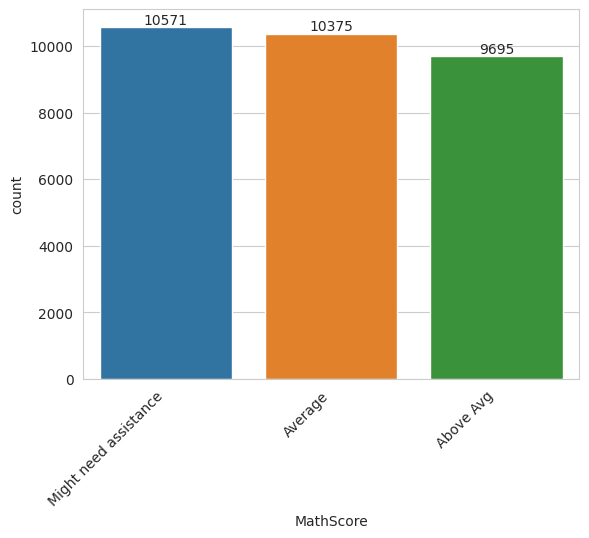

In [11]:
efd = EqualFrequencyDiscretiser(q=classes, variables=target_variable)
df_discretized = efd.fit_transform(df)
print(f"* The classes represent the following ranges: \n{efd.binner_dict_} \n")

# Plotting
fig_df_discretized = sns.countplot(data=df_discretized, x=target_variable)

# Add custom labels to bars
for container in fig_df_discretized.containers:
    plt.bar_label(container, label_type='edge')

plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45, ha='right')

plt.show()

In [12]:
df_discretized.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,C,bachelor,standard,not completed,1
1,female,C,college,standard,not completed,1
2,female,B,masters,standard,not completed,2
3,male,A,associates,free,not completed,0
4,male,C,college,standard,not completed,2


### Start model tests
split data into train and test sets and plot the results

* MathScore Train set: (24512, 5) (24512,) 
* MathScore Test set: (6129, 5) (6129,)


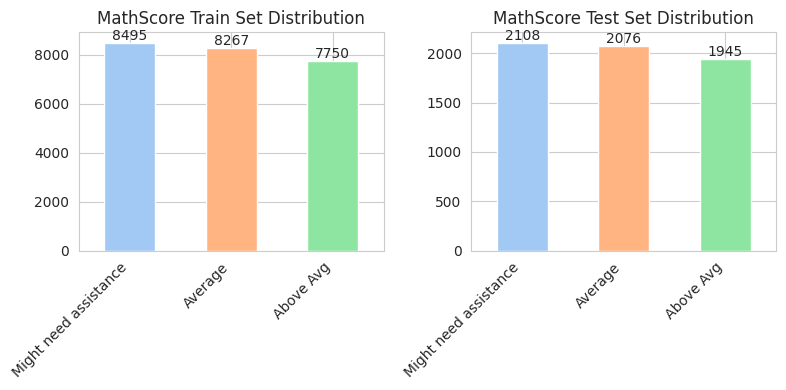

In [13]:
train_features, test_features, train_scores, test_scores = train_test_split(
    df_discretized.drop(target_variable, axis=1),
    df_discretized[target_variable],
    test_size=0.2,
    random_state=rs
)

print(f"* {target_variable} Train set:", train_features.shape, train_scores.shape, f"\n* {target_variable} Test set:", test_features.shape, test_scores.shape)

# Plot Styles
sns.set_style("whitegrid")
pastel_palette = sns.color_palette("pastel", n_colors=max(len(train_scores.value_counts()), len(test_scores.value_counts())))
plt.figure(figsize=(8, 4))

# Plot Train Set Distribution
plt.subplot(1, 2, 1)
train_counts = train_scores.value_counts()
train_counts.plot(kind='bar', title=f'{target_variable} Train Set Distribution', color=pastel_palette[:len(train_counts)])

# Add custom labels for the train set
for container in plt.gca().containers:
    plt.bar_label(container, label_type='edge')

plt.xticks(ticks=range(len(train_counts)), labels=class_labels, rotation=45, ha='right')

# Plot Test Set Distribution
plt.subplot(1, 2, 2)
test_counts = test_scores.value_counts()
test_counts.plot(kind='bar', title=f'{target_variable} Test Set Distribution', color=pastel_palette[:len(test_counts)])

# Add custom labels for the test set
for container in plt.gca().containers:
    plt.bar_label(container, label_type='edge')

plt.xticks(ticks=range(len(test_counts)), labels=class_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Analysis
There is a slight imbalance in the Training set. So I will enable the balancing step to adjust using undersampling as there are many data rows available.

### Balance Data If Required
set **balance=True** at the top if required.

** Balanced Dataset Shape **

* MathScore Train set: (23250, 5) (23250,) 
* MathScore Test set: (6129, 5) (6129,)


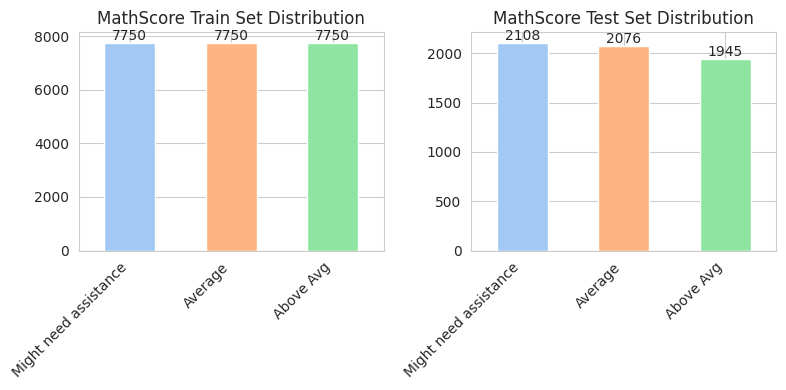

In [16]:
if balance:
    undersample = RandomUnderSampler(random_state=0)
    train_features, train_scores = undersample.fit_resample(train_features, train_scores)
    print('** Balanced Dataset Shape **\n')
    print(f"* {target_variable} Train set:", train_features.shape, train_scores.shape, f"\n* {target_variable} Test set:", test_features.shape, test_scores.shape)

    # Plot Styles
    sns.set_style("whitegrid")
    pastel_palette = sns.color_palette("pastel", n_colors=max(len(train_scores.value_counts()), len(test_scores.value_counts())))
    plt.figure(figsize=(8, 4))

    # Plot Train Set Distribution
    plt.subplot(1, 2, 1)
    train_counts = train_scores.value_counts()
    train_counts.plot(kind='bar', title=f'{target_variable} Train Set Distribution', color=pastel_palette[:len(train_counts)])

    # Add custom labels for the train set
    for container in plt.gca().containers:
        plt.bar_label(container, label_type='edge')

    plt.xticks(ticks=range(len(train_counts)), labels=class_labels, rotation=45, ha='right')

    # Plot Test Set Distribution
    plt.subplot(1, 2, 2)
    test_counts = test_scores.value_counts()
    test_counts.plot(kind='bar', title=f'{target_variable} Test Set Distribution', color=pastel_palette[:len(test_counts)])

    # Add custom labels for the test set
    for container in plt.gca().containers:
        plt.bar_label(container, label_type='edge')

    plt.xticks(ticks=range(len(test_counts)), labels=class_labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

else:
    print('** Balancing Step skipped **')

### Search for best algorithm using default hyperparameters

In [17]:
model_search = HyperparameterOptimizationSearch(models=models_list, parameters=parameter_defaults)
model_search.fit(train_features, train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be re


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [18]:
classifier_summary, grid_search_pipelines = model_search.score_summary(sort_by='mean_score')
classifier_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
5,AdaBoostClassifier,0.61871,0.651226,0.672903,0.01809
0,XGBClassifier,0.525806,0.542452,0.556129,0.013275
1,DecisionTreeClassifier,0.487097,0.504,0.518065,0.013858
2,RandomForestClassifier,0.487097,0.504,0.518065,0.013858
3,GradientBoostingClassifier,0.487097,0.504,0.518065,0.013858
4,ExtraTreesClassifier,0.487097,0.504,0.518065,0.013858


### Analysis
Reducing the bins to 3 has reduced the score of teh AdaBoostClassifier to 0.65. This is still abovethe desired value of 0.6. XGBBoost is only slightly lower at 0.54 so it is possible with some optimized hyperparameters that it might achieve a better result. The next step will therfore use the 2 best Classifiers and generate results for different hyperparameter combinations to see if the value can be improved.

### Determine best n models and fetch their recommended hyperparameters from the list:
In the function below uses **n** set at the beginning of the notebook to set how many of the best models to test with alternate hyperparameters. **Default should be 1 or 2**.<br>
3 or more might not achieve any better results and also result in very long calculation times!

In [20]:
def select_best_n_with_params(performance_summary, models_dict, params_dict, n):
    best_performers = performance_summary.sort_values(by='mean_score', ascending=False).head(n)
    
    best_models = {name: models_dict[name] for name in best_performers['estimator'] if name in models_dict}
    best_params = {name: params_dict[name] for name in best_performers['estimator'] if name in params_dict}
    
    # Create human-readable format
    print(f"Best {n} Models and hyperparameterlist for tuning:\n")
    print("-" * 40)
    for name in best_models:
        print(f"Model: {name}")
        print("Parameters:")
        if name in best_params:
            for param, values in best_params[name].items():
                print(f"  {param}: {values}")
        else:
            print("  No parameters listed.")
        print("-" * 40)

    return best_models, best_params

best_models, best_params = select_best_n_with_params(classifier_summary, models_list, parameter_list, n)

Best 2 Models and hyperparameterlist for tuning:

----------------------------------------
Model: AdaBoostClassifier
Parameters:
  model__n_estimators: [50, 25, 80, 150]
  model__learning_rate: [1, 0.1, 2]
----------------------------------------
Model: XGBClassifier
Parameters:
  model__n_estimators: [30, 80, 200]
  model__max_depth: [None, 3, 15]
  model__learning_rate: [0.01, 0.1, 0.001]
  model__gamma: [0, 0.1]
----------------------------------------


In [21]:
parameters_search = HyperparameterOptimizationSearch(models=best_models, parameters=parameter_list)
parameters_search.fit(train_features, train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be re

In [22]:
parameters_summary, parameters_pipeliness = parameters_search.score_summary(sort_by='mean_score')
parameters_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__learning_rate,model__n_estimators,model__gamma,model__max_depth
3,AdaBoostClassifier,0.61871,0.652516,0.672903,0.018883,1,150,NaN,NaN
2,AdaBoostClassifier,0.61871,0.652516,0.672903,0.018883,1,80,NaN,NaN
0,AdaBoostClassifier,0.61871,0.651226,0.672903,0.01809,1,50,NaN,NaN
1,AdaBoostClassifier,0.618065,0.649677,0.672903,0.018747,1,25,NaN,NaN
7,AdaBoostClassifier,0.562581,0.615871,0.648387,0.031391,0.1,150,NaN,NaN


### Analysis
Trying different Hyperparameters did not imoprove the performance of the AdaBoostClassifier.

In [23]:
best_model = parameters_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

In [24]:
best_parameters = parameters_pipeliness[best_model].best_params_
best_parameters

{'model__learning_rate': 1, 'model__n_estimators': 80}

In [25]:
test_pipeline = parameters_pipeliness[best_model].best_estimator_
test_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'EthnicGroup',
                                           'ParentEduc', 'LunchType',
                                           'TestPrep'])),
                ('feature_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=42))),
                ('model',
                 AdaBoostClassifier(learning_rate=1, n_estimators=80,
                                    random_state=42))])

* These are the 2 most important features in descending order. The model was trained on them: 
['EthnicGroup', 'ParentEduc']


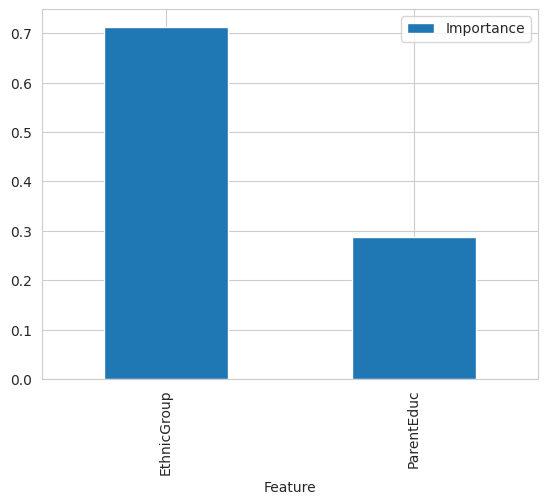

In [26]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(test_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(train_features)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[test_pipeline['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[test_pipeline['feature_selection'].get_support()],
          'Importance': test_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

maths_efd_2_best_features = df_feature_importance['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Analysis
The hyperparameter optimization and pipeline test has narrowed down the feature importance to 'EthnicGroup' and 'ParentEduc'. This is better than a single feature to predict scores, but the overall accuracy is still low.

### Classification bin cutoff determined by discretizer:

In [27]:
efd.binner_dict_[target_variable]

[-inf, 60.0, 74.0, inf]

### Define classification labels for the bins:

In [28]:
label_map = class_labels
label_map

['Might need assistance', 'Average', 'Above Avg']

### Calculate and export Confusion Matrix for Training and Test Data

In [29]:
clf_performance(
    train_features,
    train_scores,
    test_features,
    test_scores,
    test_pipeline,
    label_map,
    target_variable)

Mathscore - Train Set

#### Confusion Matrix

|                                  |   Actual Might need assistance |   Actual Average |   Actual Above Avg |
|:---------------------------------|-------------------------------:|-----------------:|-------------------:|
| Prediction Might need assistance |                           5132 |              553 |               2065 |
| Prediction Average               |                           4196 |              599 |               2955 |
| Prediction Above Avg             |                           3033 |              588 |               4129 |

#### Classification Report

|                       | precision   | recall   |   f1-score | support   |
|:----------------------|:------------|:---------|-----------:|:----------|
| Might need assistance | 0.415       | 0.662    |      0.51  | 7750      |
| Average               | 0.344       | 0.077    |      0.126 | 7750      |
| Above Avg             | 0.451       | 0.533    |      0.489 | 7750   

## Save Model to disk automatically

In [30]:
if save_model:
    # Define which files to save/update
    target = target_variable
    file_names = [
        f"{target}-train-features.csv",
        f"{target}-train-scores.csv",
        f"{target}-test-features.csv",
        f"{target}-test-scores.csv",
        f"{target}-model.pkl",
        f"{target}-labels.pkl",
        f"{target}-feature-importance.png",
    ]

    # Ensure the directory exists
    os.makedirs(file_path, exist_ok=True)

    # Remove files if they exist
    print(f'*** Removing previous files  ***')
    for name in file_names:
        file = os.path.join(file_path, name)
        if os.path.exists(file):
            os.remove(file)
            print(f"{file} removed")
        else:
            print(f"{file} does not exist")

    print('')

    # Save .csv files
    print(f'*** Creating files in: {file_path} ***')

    math_train_features.to_csv(f"{file_path}/{target}-train-features.csv", index=False)
    print(f'{target}-train-features.csv created')

    math_train_scores.to_csv(f"{file_path}/{target}-train-scores.csv", index=False)
    print(f'{target}-train-scores.csv created')

    math_test_features.to_csv(f"{file_path}/{target}-test-features.csv", index=False)
    print(f'{target}-test-features.csv created')

    math_test_scores.to_csv(f"{file_path}/{target}-test-scores.csv", index=False)
    print(f'{target}-test-scores.csv created')

    # Save .pkl model files
    joblib.dump(value=pipeline_clf_final, filename=f"{file_path}/{target}-model.pkl")
    print(f'{target}_model.pkl created')

    joblib.dump(value=label_map, filename=f"{file_path}/{target}-labels.pkl")
    print(f'{target}_labels created')

    # Save features plot image
    df_feature_importance_final.plot(kind='bar',x='Feature',y='Importance')
    plt.savefig(f'{file_path}/{target}-feature-importance.png', bbox_inches='tight')
else:
    print('Model not saved.')

Model not saved.


## Conclusion
The 3 bin approach also failed to significantly predict the majority of the students in the average class. Recalls of 0.67 and 0.52 for Assistance needed and above average are also low and in general the accuracy of 0.418 is not a promising result, as can bee seen by the fact that the model predicts 1162 students who might need assistance as average where the predicted average students only matched 161 times.
It seems the 2 bin approach need to be investigated to achieve the business model objectives.